# Classifying Clothing Images 

This time we be will be using the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist), a drop-in replacement for the MNIST dataset. Fashion-MNIST is a set of 28x28 greyscale images of clothes. It's more complex than MNIST, so it's a better representation of the actual performance of our network, and a better representation of datasets we'll use in the real world. 
1. [Building A Network (Using nn.Module)](#nn.module) 
1. [Building A Network (Using nn.Sequential)](#nn.sequential) 

In [1]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5, ) ,(0.5, ))
                               ])
# Download and load training data 
train_set = datasets.FashionMNIST('F_MNIST_data/', download = True, train = True, transform = transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle = True) 

# Download and load test data 
test_set = datasets.FashionMNIST('F_MNIST_data/', download =True, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)


Here how one of the images looks like. 

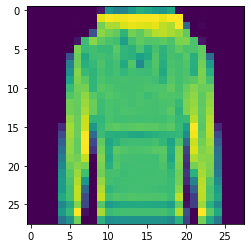

In [2]:
image, label = next(iter(train_loader))
%matplotlib inline
import matplotlib.pyplot as plt 
plt.imshow(image[0].numpy().squeeze())

Similar to MNIST Digits dataset, our images have a size of 1x28x28.

In [3]:
print('Shape of an image:', image[0].shape)
print('Shape of a label:', label[0].shape)

Shape of an image: torch.Size([1, 28, 28])
Shape of a label: torch.Size([])


<a id='nn.module'></a>
## 1. Building A Network (Using nn.Module)

In [4]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x        

## Train the network

Now create a network and train it. First define the [criterion](http://pytorch.org/docs/master/nn.html#loss-functions) (something like `nn.CrossEntropyLoss` or `nn.NLLLoss`) and [the optimizer](http://pytorch.org/docs/master/optim.html) (typically `optim.SGD` or `optim.Adam`).

Then write the training code. Remember the training pass is a fairly straightforward process:

* Make a forward pass through the network to get the logits 
* Use the logits to calculate the loss
* Perform a backward pass through the network with `loss.backward()` to calculate the gradients
* Take a step with the optimizer to update the weights

By adjusting the hyperparameters (hidden units, learning rate, etc), you should be able to get the training loss below 0.4.

In [5]:
model_1 = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model_1.parameters(), lr=0.003)

epochs = 10

for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        log_probs = model_1(images)
        loss = criterion(log_probs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Epoch {e+1} - Training loss: {running_loss/len(train_loader)}")


Epoch 1 - Training loss: 0.510286158367769
Epoch 2 - Training loss: 0.38649385200062797
Epoch 3 - Training loss: 0.354647605038528
Epoch 4 - Training loss: 0.3315084570252311
Epoch 5 - Training loss: 0.315382733273862
Epoch 6 - Training loss: 0.29850515573104813
Epoch 7 - Training loss: 0.29162624863578057
Epoch 8 - Training loss: 0.2825122163938815
Epoch 9 - Training loss: 0.26695184596280047
Epoch 10 - Training loss: 0.26267284697799415


In [6]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def prob_dist(img, label, model):
    '''
    Given a 1x28x28 image and a trained model, draws two sublpots of the image 
    itself and the prediction of the trained model about class of the image
    '''
    
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.imshow(img.numpy().squeeze(), cmap = 'Greys_r')
    ax1.set_title(f'Actual Class {label}')

    log_probs = model(img)
    probs = torch.exp(log_probs)
    
    classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal','Shirt', 'Sneaker', 'Bag', 'Ankle Boot']
    class_pos = np.arange(len(classes))
    plt.sca(ax2)
    ax2.barh(class_pos, np.array(probs.detach().numpy().tolist()[0]), align='center')
    ax2.set_xlim(0,1)
    ax2.set_yticks(class_pos) 
    ax2.set_yticklabels(classes)
    
    fig.tight_layout(pad=3.0)
        
    plt.show()

Now we check our first model's predictions for some of the images in our test set.

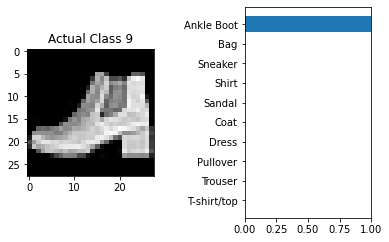

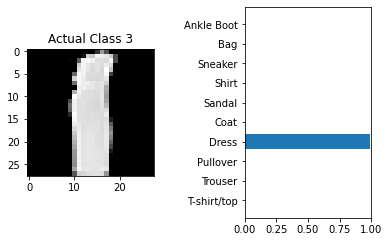

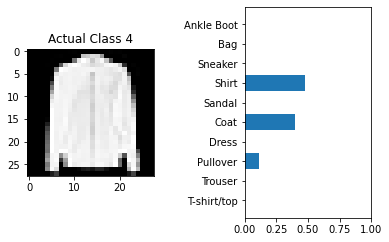

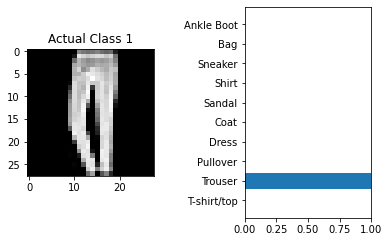

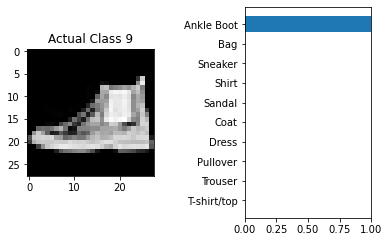

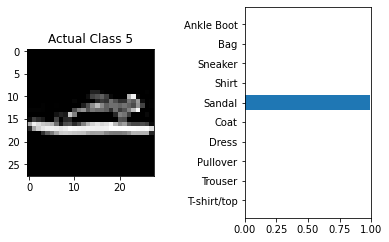

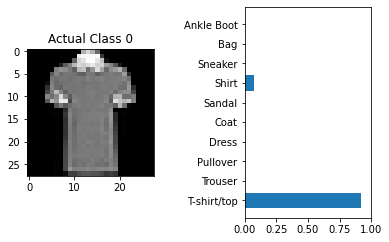

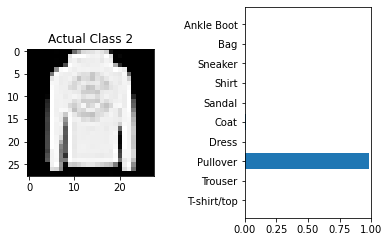

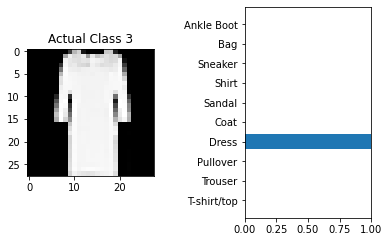

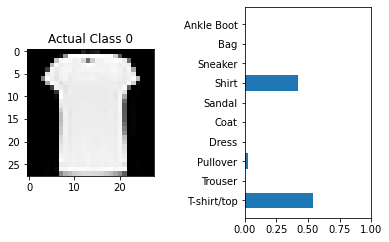

In [7]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

for i in range(10):
    prob_dist(images[i],labels[i], model_1)

<a id='nn.sequential'></a>
## 2. Building A Network (Using nn.Sequential) 

Now we will build the same model `as model_2`, however, this time we will use `nn.Sequential`. 

In [8]:
import torch 
from torch import nn, optim

model_2 = nn.Sequential(nn.Linear(784, 256),
                        nn.ReLU(), 
                        nn.Linear(256,128), 
                        nn.ReLU(), 
                        nn.Linear(128, 64), 
                        nn.ReLU(), 
                        nn.Linear(64,10), 
                        nn.LogSoftmax(dim=1)
                       )

criterion = nn.NLLLoss()
optimizer = optim.Adam(model_2.parameters(), lr=0.003)

epochs = 10 

for e in range(epochs): 
    running_loss = 0
    for images, labels in train_loader: 
        # Flatten the input
        images = images.view(images.shape[0], -1)
        
        # Reset the grad(), calculate the loss, backward pass
        optimizer.zero_grad()
        output = model_2(images)  
        loss = criterion(output, labels)
        loss.backward()
        
        # Update the weights
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f'Epoch: {e+1}\tTraining Loss: {running_loss/len(train_loader)}')

Epoch: 1	Training Loss: 0.5115081599589858
Epoch: 2	Training Loss: 0.3889667527603188
Epoch: 3	Training Loss: 0.3540912952218483
Epoch: 4	Training Loss: 0.3323859753829838
Epoch: 5	Training Loss: 0.3150966965011569
Epoch: 6	Training Loss: 0.3028445601669837
Epoch: 7	Training Loss: 0.2902091845814417
Epoch: 8	Training Loss: 0.28671734707791413
Epoch: 9	Training Loss: 0.27615092288075227
Epoch: 10	Training Loss: 0.2629794803207744


Now we check our second model's predictions for some of the images in our test set.

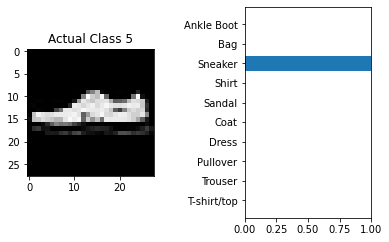

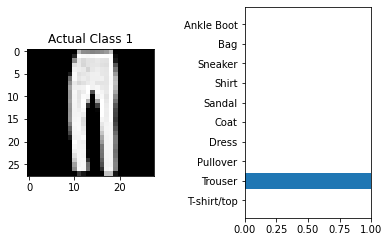

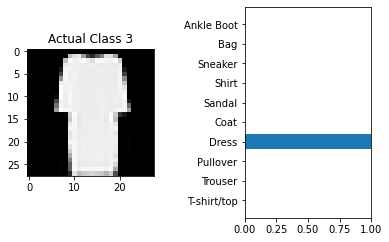

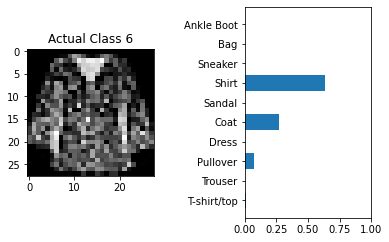

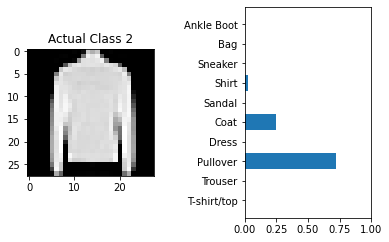

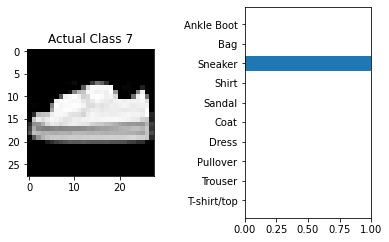

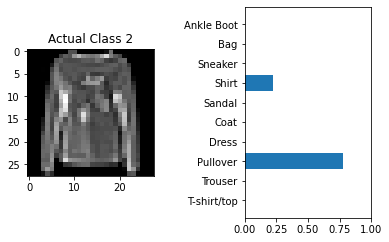

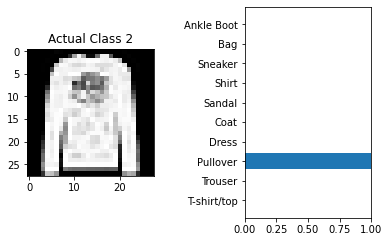

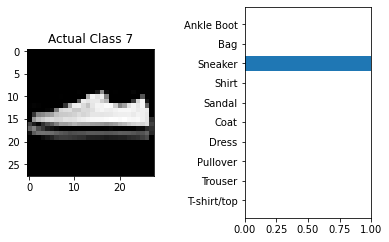

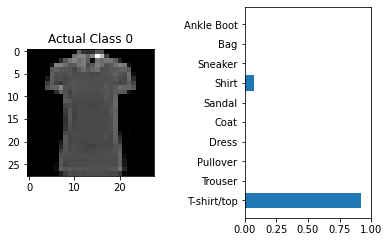

In [9]:
# get one batch of test data
dataiter = iter(test_loader)
images, labels = dataiter.next()

# draw the first 10 iamges, specify their original classes, plot our networks' guess
for i in range(10):
    prob_dist(images[i],labels[i], model_1)